In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

def date_parser(s):
    """
    Parse a date string using the log file's format. For example: '2015/10/16 11:25:59.000'
    """
    without_ms = s.split('.')[0]
    return datetime.datetime.strptime(without_ms, '%Y/%m/%d %H:%M:%S')

log = pd.read_csv('data/log.csv', parse_dates=['startTime', 'completeTime'], date_parser=date_parser)
log.head()

,case,event,startTime,completeTime,office_u,variantindex,NumberComplaints,gender,office_w,variant,...,complainttopic_en,vhost,complainttopicid,ipid,NumberQuestionsSoFar,questionsubtheme_en,questionsubthemeid,complainttheme_en,complaintsubtheme_en,service_detail
0,1445,NaN,2015-08-07 10:51:41,2015-08-07 10:51:41,296,2.0,0,M,291,Variant 2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1445,Visit page mijn_cv,2015-08-07 10:52:27,2015-08-07 10:52:27,296,2.0,0,M,291,Variant 2,...,NaN,digid.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1445,Visit page home,2015-08-07 10:53:08,2015-08-07 10:53:08,296,2.0,0,M,291,Variant 2,...,NaN,www.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1445,Visit page mijn_cv,2015-08-07 10:53:14,2015-08-07 10:53:14,296,2.0,0,M,291,Variant 2,...,NaN,digid.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
4,1445,Visit page home,2015-08-07 10:53:38,2015-08-15 19:05:12,296,2.0,0,M,291,Variant 2,...,NaN,www.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN


<h2>  Data Quality </h2>

Lets start by checking the NaN counts. Are there columns with many missing values?

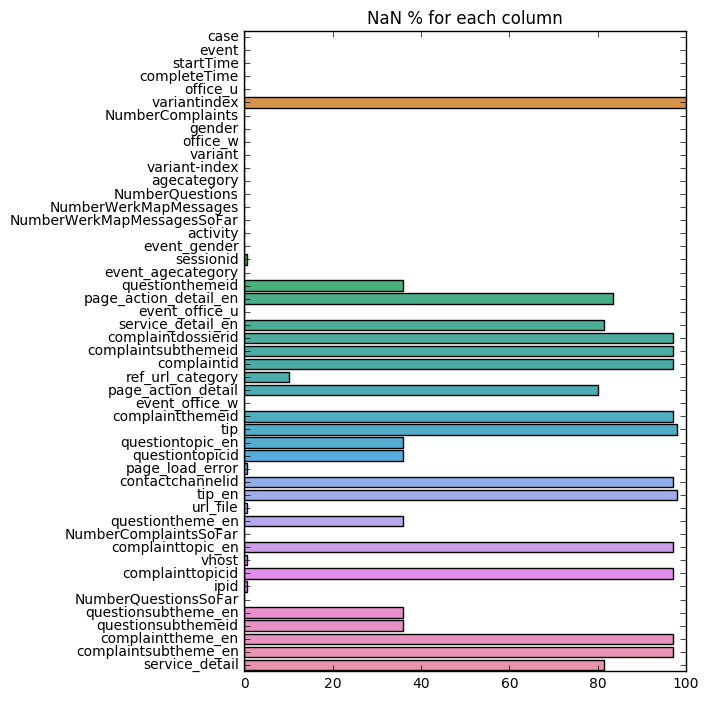

In [56]:
null = log.isnull().sum() * 100 / len(log)
null.head()

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(5.7, 8.27)

sns.barplot(x=null, y=null.index).set_title('NaN % for each column')
plt.show()

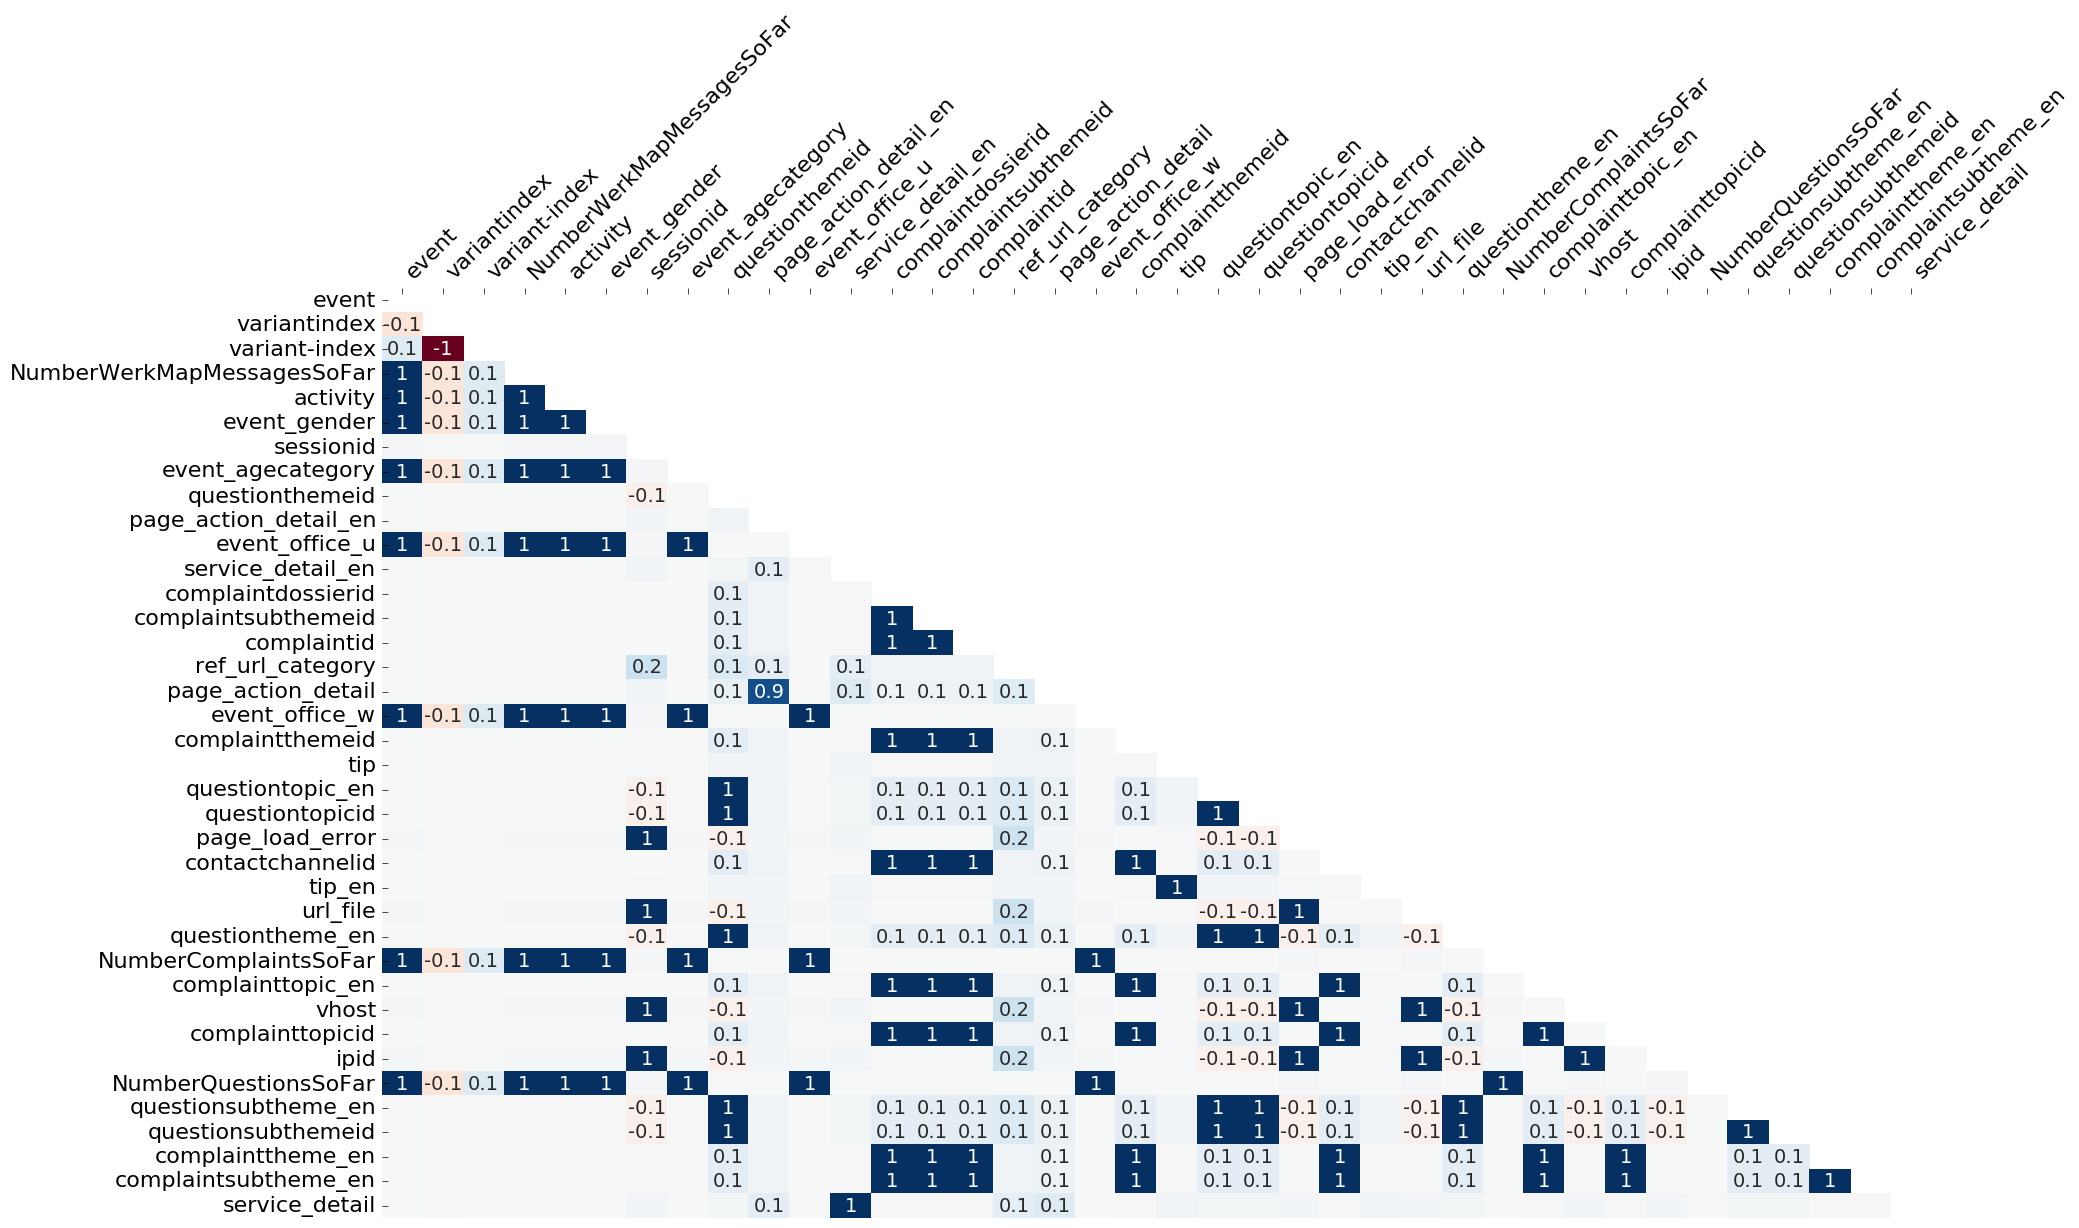

In [57]:
import missingno as msno
msno.heatmap(log)

<h3> Missing value conditional probability </h3>

The heatmap above shows features that tend to either existing or missing together. Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

<h2> Unique values </h2>

Lets now look at the distribution of unique values in each column. This can provide an insight into their meaning.

In [58]:
log.apply(pd.Series.nunique)

case                            4226
event                            246
startTime                     481325
completeTime                  481324
office_u                          13
variantindex                       1
NumberComplaints                   6
gender                             2
office_w                          40
variant                         4225
variant-index                   4224
agecategory                        4
NumberQuestions                   40
NumberWerkMapMessages             37
NumberWerkMapMessagesSoFar        54
activity                         246
event_gender                       2
sessionid                     106221
event_agecategory                  4
questionthemeid                   14
page_action_detail_en             20
event_office_u                    13
service_detail_en                 15
complaintdossierid               256
complaintsubthemeid                5
complaintid                      289
ref_url_category                   9
p

<b> Some of these numbers are interesting. Specifically the following conclusions can be drawn: </b>

- The case column refers to the signed in users. There are **4226 unique users** in our database


- The sessionid refers to the internet session. There are **106221 different sessions**, therefore each user visited our site **25 times on average** 


- There are **246 different events**  (all of them referring to specific URL visits). This info is recorded twice (**activity and event columns seem to be the same**). We can therefore safely remove one of them.


- Ages are binned into **4 categories** , probably for anonimization purposes.

<h3> Lets look with some more detail into the different values for interesting features </h3>

In [59]:
# Events without an event type are pretty useless so we might as well drop them
log.dropna(axis=0, subset=['event'], inplace=True)

events = log['event'].unique()
not_page_visits = [event for event in events if not event.startswith('Visit page')]
not_page_visits

['Question', 'Werkmap message', 'File Complaint']

<h3> Almost all events are page visits! </h3>

As we can see, out of 246 unique events, 243 are visits of specific URL pages. The 3 remaining are very important for our case since we are mostly interested in traces that lead to a call, a question or a complaint. 

<b> Lets take a closer look at this events. </b>

In [60]:
def event_percentage(event):
    return len(log.loc[log['event'] == event]) * 100 / len(log)

for event in not_page_visits:
    print('{:.2f}% of records refer to a {}'.format(event_percentage(event), event))

4.14% of records refer to a Question
2.31% of records refer to a Werkmap message
0.06% of records refer to a File Complaint


In [61]:
complain_cols = [c for c in log.columns if 'complaint' in c] 
question_cols = [c for c in log.columns if 'question' in c]

<h2> Filtering interesting traces </h2>

We are mostly interested in traces that conclude or include at least one instance of a "slow" channel. This could be a question asked to the call center, a discussion initiated on the website (identified by the presence of WerkMap messages) or a cimplaint filed. We can achieve that by first moving to a trace representation and then filtering accordingly.

In [62]:
log.head()

,case,event,startTime,completeTime,office_u,variantindex,NumberComplaints,gender,office_w,variant,...,complainttopic_en,vhost,complainttopicid,ipid,NumberQuestionsSoFar,questionsubtheme_en,questionsubthemeid,complainttheme_en,complaintsubtheme_en,service_detail
1,1445,Visit page mijn_cv,2015-08-07 10:52:27,2015-08-07 10:52:27,296,2.0,0,M,291,Variant 2,...,NaN,digid.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1445,Visit page home,2015-08-07 10:53:08,2015-08-07 10:53:08,296,2.0,0,M,291,Variant 2,...,NaN,www.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1445,Visit page mijn_cv,2015-08-07 10:53:14,2015-08-07 10:53:14,296,2.0,0,M,291,Variant 2,...,NaN,digid.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
4,1445,Visit page home,2015-08-07 10:53:38,2015-08-15 19:05:12,296,2.0,0,M,291,Variant 2,...,NaN,www.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
5,1445,Visit page foutopgetreden.html,2015-08-15 19:05:15,2015-08-15 19:05:15,296,2.0,0,M,291,Variant 2,...,NaN,www.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN


In [89]:
# Make sure the list of activities per session will be ordered by time
log.sort_values(['sessionid', 'startTime'], ascending=[True, True], inplace=True)

# Define aggregations when looking at each session
aggregations = {'event': lambda x: list(x), 
                'startTime': 'first', 
                'completeTime': 'last', 
                'gender': 'first'
               }
sessions = log.groupby('sessionid', as_index=False).agg(aggregations)
sessions.head()

,sessionid,event,completeTime,startTime,gender
0,92.0,"[Visit page mijn_werkmap, Question]",2015-10-16 11:25:59,2015-10-14 14:59:37,M
1,358.0,"[Visit page mijn_berichten, Visit page taken, ...",2015-10-15 13:54:38,2015-10-15 13:34:42,V
2,447.0,"[Visit page mijn_berichten, Werkmap message]",2015-10-07 11:44:35,2015-10-07 11:37:32,M
3,1117.0,"[Visit page home, Visit page taken, Visit page...",2015-11-02 10:16:02,2015-10-30 14:28:33,V
4,1472.0,"[Visit page mijn_cv, Visit page mijn_werkmap, ...",2015-10-09 11:00:31,2015-10-09 10:37:38,V


<h2> Throughtput </h2>

It is interesting to check the distribution of time spent during each session and perhaps relate it to other session atributes, like demographics etc. We define a session's duration as the time spent between the start of its first event and the complete of its last event.

In [102]:
sessions['duration'] = sessions['completeTime'] - sessions['startTime']

def compute_average(durations):
    """
    Compute the average from a (potentially long) iterable of timedeltas.
    """
    size = len(durations)
    zero = datetime.timedelta(0)
    try:
        return sum(durations, zero) / len(durations)
    except OverflowError:
        print("Duration list too big, processing in chunks")
        return sum(durations[0:50000], zero) / size + sum(durations[50000: ], zero) / size
                
average_duration = compute_average(sessions['duration'])
average_duration

Duration list too big, processing in chunks


Timedelta('1 days 14:30:11.567816')

In [109]:
def filter_on_event(df, event, include=True):
    def event_includes(event_list, event, include=True):
        if include:
            return event in event_list
        return event not in event_list
    
    return df[df['event'].apply(event_includes, args=(event, include))] 

account_creation_sessions = filter_on_event(sessions, 'Visit page account_aanmelden')
account_making_duration = compute_average(account_creation_sessions['duration'])
print('Traces that include an account creation take {} on average'.format(account_making_duration))

question_sessions = filter_on_event(sessions, 'Question')
question_duration = compute_average(question_sessions['duration'])
print('Traces that include a question take {} on average'.format(question_duration))

Traces that include an account creation take 5 days 00:45:31.833333 on average
Traces that include a question take 8 days 19:26:11.951856 on average


<h2> Are certain demographic groups more/less probable to use slow communication channels </h2>

In [113]:
len(question_sessions[question_sessions['gender'] == 'V']) / len(question_sessions)

0.4919236417033774